# The Poisson Equation

We aim to solve the Poisson equation
\begin{align}
\begin{split}
  -\Delta u &= f \quad \text{in }\Omega,
  \\
  u &= g \quad \text{on }\partial\Omega.
\end{split}
\end{align}
We set $\Omega = [0,1]^2$ and use the manufactured solution
\begin{equation*}
  u(x,y) = \sin(\pi x)\sin(\pi y).
\end{equation*}
The corresponding right-hand side is $f=2\pi^2 u$ and the boundary values vanish, i.e., $g=0$. Formulating the Poisson equation as residual minimization, i.e., in the PINN form yields
\begin{equation*}
        E(u)
         =
         \frac12 \lVert \Delta u + f \rVert_{L^2(\Omega)}^2
         +
         \frac12 \lVert u - g \rVert_{L^2(\partial\Omega)}^2.
\end{equation*}
To discretize, one can choose collocation points $\{x_i\}_{i=1,\dots,N_\Omega}$ in $\Omega$ and $\{x^b_i\}_{i=1,\dots,N_{\partial\Omega}}$ on the boundary $\partial\Omega$ and define
     \begin{equation*}
         L(\theta)
         =
         \frac{|\Omega|}{2N_{\Omega}}
         \sum_{i=1}^{N_{\Omega}}(\Delta u_\theta(x_i) + f(x_i))^2
         +
         \frac{|\partial\Omega|}{2N_{\partial\Omega}}
         \sum_{i=1}^{N_{\partial\Omega}}(u_\theta(x^b_i) - g(x^b_i))^2.
\end{equation*}


The first block of code serves the purpose of drawing the quadrature points.

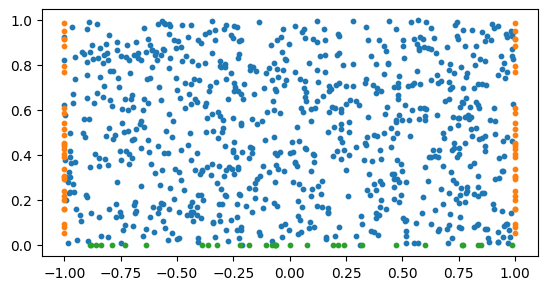

In [80]:
import torch
from matplotlib import pyplot as plt
import numpy as np
from copy import copy

torch.set_default_device('cuda')
torch.set_default_dtype(torch.float64)

# number of points in Omega
N_Omega = 2000
N_Gamma = 100
key = torch.cuda.manual_seed(3)
mu = 0.01 / np.pi
# dimension of Omega

x = (-1 - 1) * torch.rand(30) + 1
t = (0 - 1) * torch.rand(30) + 1

x1 = (-1 - 1) * torch.rand(800) + 1
t1 = (0 - 1) * torch.rand(800) + 1

x_Omega = torch.concat((x1.reshape(-1,1), t1.reshape(-1,1)), dim=1)

bnd_init = torch.cartesian_prod(x, torch.tensor([0.]))
val_init = -torch.sin(np.pi * x)

bnd1 = torch.cartesian_prod(torch.tensor([-1.]), t)
val1 = torch.zeros(30,)

bnd2 = torch.cartesian_prod(torch.tensor([1.]), t)
val2 = torch.zeros(30,)

x_Gamma = torch.concat((bnd1, bnd2))
val_Gamma = torch.concat((val1, val2))



x_eval = torch.cartesian_prod(torch.linspace(-1, 1, 10), torch.linspace(0, 1, 10))

# visualize the sampling points
plt.scatter(x_Omega[:, 0].cpu(), x_Omega[:, 1].cpu(), s = 10)
plt.scatter(x_Gamma[:, 0].cpu(), x_Gamma[:, 1].cpu(), s = 10)
plt.scatter(bnd_init[:, 0].cpu(), bnd_init[:, 1].cpu(), s = 10)
plt.gca().set_aspect(1.)
plt.show()

In [81]:
model = torch.nn.Sequential(
            torch.nn.Linear(2, 20),
            torch.nn.Tanh(),
            torch.nn.Linear(20, 20),
            torch.nn.Tanh(),
            torch.nn.Linear(20, 20),
            torch.nn.Tanh(),
            torch.nn.Linear(20, 1)
        )

In [82]:
def pde(model, x):
    x.requires_grad=True
    u = model(x)
    u = u[:, 0:1]

    du_g, = torch.autograd.grad(u.sum(0), x, create_graph=True)
    u_x, u_t = du_g[:, :1], du_g[:, 1:]

    d2u_g, = torch.autograd.grad(u_x.sum(0), x, create_graph=True)

    u_xx = d2u_g[:, 0:1]

    # Loss function for the Euler Equations
    res = u_t + u*u_x - mu*u_xx

    return res

def boundary(model, x):
    p_bc_nn = model(x)[:, 0:1]
    bcs = p_bc_nn - val_Gamma.reshape(-1,1)
    return bcs

def initial(model, x):
    p_bc_nn = model(x)[:, 0:1]
    bcs = p_bc_nn - val_init.reshape(-1,1)
    return bcs

def loss_pde(model, x):
    res = pde(model, x)
    return torch.mean(res**2)

def loss_bound(model, x):
    bcs = boundary(model, x)

    return torch.mean(bcs**2)

def loss_init(model, x):
    bcs = initial(model, x)

    return torch.mean(bcs**2)

def loss(model, x_r, x_b, x_init):
    return loss_pde(model, x_r) + loss_bound(model, x_b) + loss_init(model, x_init)

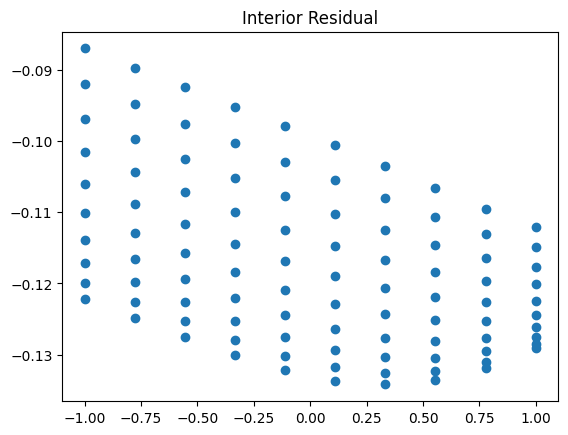

In [83]:
# we can visualize the residuals if we wish
plt.scatter(x_eval[:,0].detach().cpu().numpy(), pde(model, x_eval).detach().reshape(-1).cpu())
# plt.gca().set_aspect(1.)
plt.gca().title.set_text('Interior Residual')
# plt.colorbar()
plt.show()

In [84]:
from torch.func import jacfwd, jacrev
from torch.nn.utils import vector_to_parameters, parameters_to_vector
# from torch.autograd.functional import jacobian

def replace_none_with_zero(tuple_data):
    if isinstance(tuple_data, torch.Tensor):
        tuple_data[tuple_data == None] = 0
    elif tuple_data is None:
        tuple_data = torch.tensor([0.])
    elif isinstance(tuple_data, tuple):
        new_tuple = tuple(replace_none_with_zero(item) for item in tuple_data)
        return new_tuple
    return tuple_data


def gram_factory(loss_func):

    def gramian(model, X):
        # Compute the jacobian on batched data
        def jacobian():
            jac = []
            loss = loss_func(model, X)
            for l in loss:
                j = torch.autograd.grad(l, model.parameters(), retain_graph=True, allow_unused=True)
                j = replace_none_with_zero(j)
                j = parameters_to_vector(j).reshape(1, -1)
                # j = j.T @ j
                jac.append(j)
            return torch.cat(jac) #torch.stack(jac, dim=0)

        J = jacobian()
        return 1/len(X)*J.T@J #torch.mean(J, dim=0)

    return gramian

gram_int  = gram_factory(pde)
gram_bdry = gram_factory(boundary)
gram_init = gram_factory(initial)

In [85]:
def grid_line_search_factory(loss, steps):

    def loss_at_step(step, model, tangent_params):
        params = parameters_to_vector(model.parameters())
        new_params = params - step*tangent_params
        vector_to_parameters(new_params, model.parameters())
        loss_val = loss(model, x_Omega, x_Gamma, bnd_init)
        vector_to_parameters(params, model.parameters())
        return loss_val


    def grid_line_search_update(model, tangent_params):

        losses = []
        for step in steps:
            losses.append(loss_at_step(step, model, tangent_params).reshape(1))
        losses = torch.cat(losses)
        step_size = steps[torch.argmin(losses)]

        params = parameters_to_vector(model.parameters())
        new_params = params - step_size*tangent_params
        vector_to_parameters(new_params, model.parameters())

        return step_size

    return grid_line_search_update

# set up grid line search
grid = torch.linspace(0, 20, 21)
steps = 0.5**grid
ls_update = grid_line_search_factory(loss, steps)

In [86]:
from scipy.integrate import quad

# def exact(grid):
#     return torch.exp(-torch.pi**2*grid[:,1]/4)*torch.sin(torch.pi*grid[:,0])

def exact(grid):
    mu = 0.01 / np.pi

    def f(y):
        return np.exp(-np.cos(np.pi * y) / (2 * np.pi * mu))

    def integrand1(m, x, t):
        return np.sin(np.pi * (x - m)) * f(x - m) * np.exp(-m ** 2 / (4 * mu * t))

    def integrand2(m, x, t):
        return f(x - m) * np.exp(-m ** 2 / (4 * mu * t))

    def u(x, t):
        if t == 0:
            return -np.sin(np.pi * x)
        else:
            return -quad(integrand1, -np.inf, np.inf, args=(x, t))[0] / quad(integrand2, -np.inf, np.inf, args=(x, t))[
                0]

    solution = []
    for point in grid:
        solution.append(u(point[0].item(), point[1].item()))

    return torch.tensor(solution)

def l2_norm(model, x):
    return torch.mean((model(x)-exact(x).reshape(-1,1)) ** 2) ** 0.5

l2_error = l2_norm(model, x_eval)
# h1_error = l2_error + l2_norm(v_error_abs_grad, x_eval)

# inspect the errors with the untrained network
print(f'L2 error: {l2_error} ')

C:\Users\user\AppData\Local\Temp\ipykernel_5744\287581922.py:22: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return -quad(integrand1, -np.inf, np.inf, args=(x, t))[0] / quad(integrand2, -np.inf, np.inf, args=(x, t))[
C:\Users\user\AppData\Local\Temp\ipykernel_5744\287581922.py:22: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return -quad(integrand1, -np.inf, np.inf, args=(x, t))[0] / quad(integrand2, -np.inf, np.inf, args=(x, t))[


L2 error: 0.6086760035789359 


In [87]:
from torch.autograd import grad
# from torch.linalg import lstsq
import jax.numpy as jnp
import numpy as np
import jax
from jax.numpy.linalg import lstsq
from copy import copy

jax.config.update("jax_enable_x64", True)

def torch_grad(func):
    def grad_func(model, x_r, x_b, x_init):
        y = func(model, x_r, x_b, x_init)
        grads = torch.autograd.grad(y, model.parameters(), retain_graph=True, allow_unused=True)
        grads = replace_none_with_zero(grads)
        return grads

    return grad_func

for iteration in range(2000):

    # compute gradient of loss
    grads = torch_grad(loss)(model, x_Omega, x_Gamma, bnd_init)
    f_grads = parameters_to_vector(grads)

    # assemble gramian
    G_int  = gram_int(model, x_Omega)
    G_bdry = gram_bdry(model, x_Gamma)
    G_init = gram_init(model, bnd_init)
    G      = G_int + G_bdry + G_init

    # Marquardt-Levenberg
    Id = torch.eye(len(G))
    G = torch.min(torch.tensor([loss(model, x_Omega, x_Gamma, bnd_init), 0.0])) * Id + G
    # compute natural gradient
    G = jnp.array(G.detach().cpu().numpy(), dtype=jnp.float64)
    f_grads =jnp.array(f_grads.detach().cpu().numpy(), dtype=jnp.float64)
    f_nat_grad = lstsq(G, f_grads, rcond=-1)[0]
    # if torch.isnan(f_nat_grad).sum():
        # f_nat_grad = torch.zeros_like(f_nat_grad)
    f_nat_grad = torch.from_numpy(np.array(f_nat_grad)).to(torch.float64).to('cuda')

    # one step of NGD
    actual_step = ls_update(model, f_nat_grad)

    if iteration % 5 == 0:
        # errors
        l2_error = l2_norm(model, x_Omega)

        print(
            f'NG Iteration: {iteration} with loss: {loss(model, x_Omega, x_Gamma, bnd_init)} with error '
            f'L2: {l2_error} and step: {actual_step}')

NG Iteration: 0 with loss: 0.4307521467196147 with error L2: 0.6402064737874361 and step: 9.5367431640625e-07
NG Iteration: 5 with loss: 0.3501835917613611 with error L2: 0.6029243456297667 and step: 1.52587890625e-05
NG Iteration: 10 with loss: 0.30900819688750464 with error L2: 0.5717225557513953 and step: 7.629394531249999e-06
NG Iteration: 15 with loss: 0.30161628248412803 with error L2: 0.5643047702213141 and step: 9.5367431640625e-07
NG Iteration: 20 with loss: 0.30170854139068903 with error L2: 0.5644347226828779 and step: 9.5367431640625e-07
NG Iteration: 25 with loss: 0.3017651550493099 with error L2: 0.5645294827915754 and step: 9.5367431640625e-07
NG Iteration: 30 with loss: 0.30178328789490205 with error L2: 0.5645698030669223 and step: 9.5367431640625e-07
NG Iteration: 35 with loss: 0.30182774790785166 with error L2: 0.5645862357288269 and step: 9.5367431640625e-07
NG Iteration: 40 with loss: 0.300982118186393 with error L2: 0.5605590651471853 and step: 1.52587890625e-05
N

KeyboardInterrupt: 

C:\Users\user\AppData\Local\Temp\ipykernel_5744\287581922.py:22: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return -quad(integrand1, -np.inf, np.inf, args=(x, t))[0] / quad(integrand2, -np.inf, np.inf, args=(x, t))[
C:\Users\user\AppData\Local\Temp\ipykernel_5744\287581922.py:22: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return -quad(integrand1, -np.inf, np.inf, args=(x, t))[0] / quad(integrand2, -np.inf, np.inf, args=(x, t))[


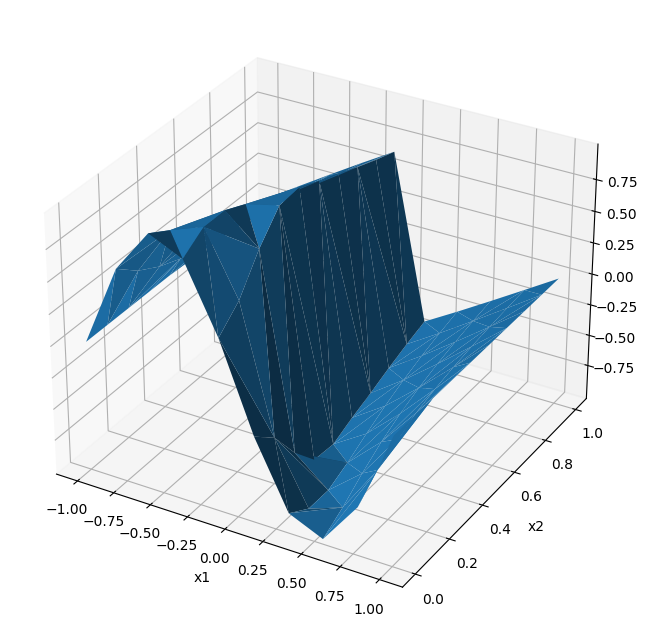

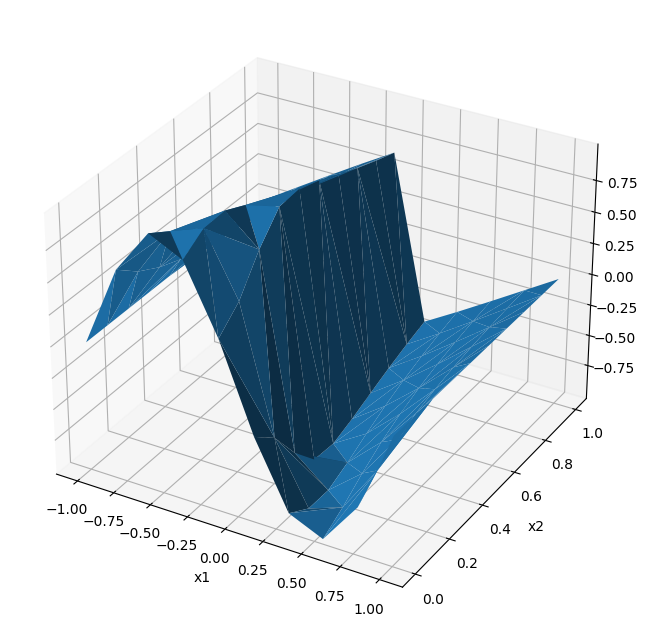

In [88]:
fig = plt.figure(figsize=(15, 8))
ax1 = fig.add_subplot(1, 1, 1, projection='3d')
ax1.plot_trisurf(x_eval[:, 0].detach().cpu().numpy(),
                    x_eval[:, 1].detach().cpu().numpy(),
                    exact(x_eval).reshape(-1).detach().cpu().numpy(),
                    linewidth=0.2, alpha=1)
ax1.set_xlabel("x1")
ax1.set_ylabel("x2")
plt.show()
fig = plt.figure(figsize=(15, 8))
ax1 = fig.add_subplot(1, 1, 1, projection='3d')
ax1.plot_trisurf(x_eval[:, 0].detach().cpu().numpy(),
                    x_eval[:, 1].detach().cpu().numpy(),
                    model(x_eval).reshape(-1).detach().cpu().numpy(),
                    linewidth=0.2, alpha=1)
ax1.set_xlabel("x1")
ax1.set_ylabel("x2")
plt.show()